In [1]:
import sys
sys.path.append('/home/jxm3/research/deidentification/unsupervised-deidentification')

from datamodule import WikipediaDataModule
from model import AbstractModel, CoordinateAscentModel
from utils import get_profile_embeddings_by_model_key

import argparse
import collections
import glob
import json
import os
import re

import datasets
import pandas as pd
import torch
import transformers
from tqdm import tqdm


from model_cfg import model_paths_dict

datasets.utils.logging.set_verbosity_error()


num_cpus = len(os.sched_getaffinity(0))


def get_profile_embeddings(model_key: str):
    profile_embeddings = get_profile_embeddings_by_model_key(model_key=model_key)

    print("concatenating train, val, and test profile embeddings")
    all_profile_embeddings = torch.cat(
        (profile_embeddings['test'], profile_embeddings['val'], profile_embeddings['train']), dim=0
    )

    print("all_profile_embeddings:", all_profile_embeddings.shape)
    return all_profile_embeddings

def load_adv_csv(dm: WikipediaDataModule, max_num_samples: int = 100) -> pd.DataFrame:
    # Load adv CSVs
    adv_df = None
    adv_csvs_folder = os.path.normpath(
        os.path.join(
            os.getcwd(), os.pardir, 'adv_csvs_full_8'
        )
    )
    print('adv_csvs_folder', adv_csvs_folder)
    model_csv_filenames = list(glob.glob(
        os.path.join(
            adv_csvs_folder,
            'model*/results*.csv'
        )
    ) )
    print("len(model_csv_filenames) =", len(model_csv_filenames))
    for filename in (model_csv_filenames):
        # print('filename:', filename)
        df = pd.read_csv(filename)
        
        if len(df) < 50: continue
        
        df = df[(df['result_type'] == 'Successful') | (df['result_type'] == 'Skipped')]
        json_filename = filename.replace('.csv', '__args.json')
        assert os.path.exists(json_filename)
        
        adv_csv_json = json.load(open(json_filename, 'r'))
        
        df["filename"] = filename
        for key, val in adv_csv_json.items():
            df[key] = val
        df["i"] = df.index
        
        df = df.rename(columns={"model": "model_name"})

        mini_df = df.iloc[:max_num_samples]

        if adv_df is None:
            adv_df = mini_df
        else:
            adv_df = pd.concat((adv_df, mini_df), axis=0)
        # print(adv_df)
    
    # Load baseline redacted data
    mini_test_dataset = dm.test_dataset[:max_num_samples]
    doc_df = pd.DataFrame(
        columns=['perturbed_text'],
        data=mini_test_dataset['document']
    )
    doc_df['model_name'] = 'document'
    doc_df['i'] = doc_df.index
    doc_df['filename'] = 'document'
    
    ner_df = pd.DataFrame(
        columns=['perturbed_text'],
        data=mini_test_dataset['document_redact_ner_bert']
    )
    ner_df['model_name'] = 'named_entity'
    ner_df['i'] = ner_df.index
    ner_df['filename'] = 'named_entity'
        
    lex_df = pd.DataFrame(
        columns=['perturbed_text'],
        data=mini_test_dataset['document_redact_lexical']
    )
    lex_df['model_name'] = 'lexical'
    lex_df['i'] = lex_df.index
    lex_df = lex_df.iloc[:max_num_samples]
    lex_df['filename'] = 'lexical'

    # Combine both adversarial and baseline redacted data
    baseline_df = pd.concat((doc_df, lex_df, ner_df), axis=0)
    for key in adv_csv_json.keys():
        if key not in baseline_df: baseline_df[key] = None
        
    
    full_df = pd.concat((adv_df, baseline_df), axis=0)
    
    # Put newlines back
    full_df['perturbed_text'] = full_df['perturbed_text'].apply(lambda s: s.replace('<SPLIT>', '\n'))

    # Standardize mask tokens
    full_df['perturbed_text'] = full_df['perturbed_text'].apply(lambda s: s.replace('[MASK]', dm.mask_token))
    full_df['perturbed_text'] = full_df['perturbed_text'].apply(lambda s: s.replace('<mask>', dm.mask_token))
    
    # Fair truncation
    full_df['original_num_words'] = full_df['perturbed_text'].map(lambda s: len(s.split()))
    for i in full_df['i'].unique():
        #         df.loc[df.loc[df['a'] == 1,'b'].index[1], 'b'] = 3
        min_num_words = full_df[full_df['i'] == i]['original_num_words'].min()
        full_df.loc[full_df[full_df['i'] == i].index, 'perturbed_text'] = (
            full_df.loc[full_df[full_df['i'] == i].index, 'perturbed_text'].map(
                lambda t: ' '.join(t.split()[:min_num_words])
            )
        )
    
    full_df['num_words'] = full_df['perturbed_text'].map(lambda s: len(s.split()))
    
    
    # This makes sure sure all documents with a given index have the same number of words.
    assert full_df.groupby('i')['num_words'].std().max() == 0.0

    return full_df


def get_adv_predictions(model_key: str, max_num_samples: int):
    checkpoint_path = model_paths_dict[model_key]
    assert isinstance(checkpoint_path, str), f"invalid checkpoint_path {checkpoint_path} for {model_key}"
    print(f"running eval on {model_key} loaded from {checkpoint_path}")
    model = CoordinateAscentModel.load_from_checkpoint(
        checkpoint_path
    )

    print(f"loading data with {num_cpus} CPUs")
    dm = WikipediaDataModule(
        document_model_name_or_path=model.document_model_name_or_path,
        profile_model_name_or_path=model.profile_model_name_or_path,
        dataset_name='wiki_bio',
        dataset_train_split='train[:256]',
        dataset_val_split='val[:256]',
        dataset_test_split='test[:100%]',
        dataset_version='1.2.0',
        num_workers=num_cpus,
        train_batch_size=256,
        eval_batch_size=256,
        max_seq_length=128,
        sample_spans=False,
    )
    dm.setup("fit")

    adv_csv = load_adv_csv(dm=dm, max_num_samples=max_num_samples)

    all_profile_embeddings = get_profile_embeddings(model_key=model_key).cuda()

    model.document_model.eval()
    model.document_model.cuda()
    model.document_embed.eval()
    model.document_embed.cuda()

    topk_values = []
    topk_idxs = []
    batch_size = 256
    i = 0
    pbar = tqdm(total=len(adv_csv), leave=False, desc='Making predictions...')
    while i < len(adv_csv):
        ex = adv_csv.iloc[i:i+batch_size]
        test_batch = dm.document_tokenizer.batch_encode_plus(
            ex['perturbed_text'].tolist(),
            max_length=dm.max_seq_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt',
        )
        test_batch = {
            f'perturbed_text__{k}': v for k,v in test_batch.items()
        }
        with torch.no_grad():
            document_embeddings = model.forward_document(batch=test_batch, document_type='perturbed_text')
            document_to_profile_logits = document_embeddings @ all_profile_embeddings.T
            document_to_profile_probs = document_to_profile_logits.softmax(dim=1)
            topk_10 = document_to_profile_probs.topk(10)
            topk_values.append(topk_10.values)
            topk_idxs.append(topk_10.indices)

        i += batch_size
        pbar.update(batch_size)
    
    adv_csv['pred_topk_values'] = torch.cat(topk_values, dim=0).cpu().tolist()
    adv_csv['pred_topk_idxs'] = torch.cat(topk_idxs, dim=0).cpu().tolist()
    
    
    model.document_model.cpu()
    model.document_embed.cpu()
    model.cpu()
    return adv_csv



In [2]:
n = 1000

# pmlm_tapas_lex_predictions = get_adv_predictions(model_key='model_3_5__epoch47', max_num_samples=n)
pmlm_tapas_predictions = get_adv_predictions(model_key='model_3_4', max_num_samples=n)
roberta_tapas_predictions = get_adv_predictions(model_key='model_3_2', max_num_samples=n)
roberta_roberta_predictions = get_adv_predictions(model_key='model_3_3', max_num_samples=n)
# TODO: drop predictions if we predicted the same thing with same hparams just different values of n. Like
# if we have filenames with n=1000 and n=100. Just take the one with largest n.

running eval on model_3_4 loaded from /home/jxm3/research/deidentification/unsupervised-deidentification/saves/ca__pmlm-a__tapas__dropout_-1.0_1.0_0.0__e3072__ls0.1/deid-wikibio-4_default/1g8o1iw3_749/checkpoints/epoch=65-step=150281-idf_total.ckpt
Initialized model with learning_rate = 5e-05 and patience 6
loading data with 8 CPUs
Initializing WikipediaDataModule with num_workers = 8 and mask token `[MASK]`
loading wiki_bio[1.2.0] split train[:256]
loading wiki_bio[1.2.0] split val[:256]
loading wiki_bio[1.2.0] split test[:100%]
                        adv_csvs_folder /home/jxm3/research/deidentification/unsupervised-deidentification/adv_csvs_full_8
len(model_csv_filenames) = 69
>> loaded 582659 train embeddings from /home/jxm3/research/deidentification/unsupervised-deidentification/embeddings/profile/model_3_4/train.pkl
>> loaded 72831 val embeddings from /home/jxm3/research/deidentification/unsupervised-deidentification/embeddings/profile/model_3_4/val.pkl
>> loaded 72831 test embed

running eval on model_3_2 loaded from /home/jxm3/research/deidentification/unsupervised-deidentification/saves/ca__roberta__tapas__dropout_-1.0_1.0_0.0__e3072__ls0.1/deid-wikibio-4_lightning_logs/ojgxa1tf_6/checkpoints/epoch=65-step=150282-idf_total.ckpt


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Initialized model with learning_rate = 0.0001 and patience 6
loading data with 8 CPUs
Initializing WikipediaDataModule with num_workers = 8 and mask token `<mask>`
loading wiki_bio[1.2.0] split train[:256]
loading wiki_bio[1.2.0] split val[:256]
loading wiki_bio[1.2.0] split test[:100%]
                        adv_csvs_folder /home/jxm3/research/deidentification/unsupervised-deidentification/adv_csvs_full_8
len(model_csv_filenames) = 71
>> loaded 582659 train embeddings from /home/jxm3/research/deidentification/unsupervised-deidentification/embeddings/profile/model_3_2/train.pkl
>> loaded 72831 val embeddings from /home/jxm3/research/deidentification/unsupervised-deidentification/embeddings/profile/model_3_2/val.pkl
>> loaded 72831 test embeddings from /home/jxm3/research/deidentification/unsupervised-deidentification/embeddings/profile/model_3_2/test.pkl
concatenating train, val, and test profile embeddings
all_profile_embeddings: torch.Size([728321, 3072])


running eval on model_3_3 loaded from /home/jxm3/research/deidentification/unsupervised-deidentification/saves/ca__roberta__dropout_-1.0_1.0_0.0__e3072__ls0.1/deid-wikibio-4_lightning_logs/2cr1gp87_28/checkpoints/epoch=68-step=157113.ckpt


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaMod

Initialized model with learning_rate = 0.0001 and patience 6
loading data with 8 CPUs
Initializing WikipediaDataModule with num_workers = 8 and mask token `<mask>`
loading wiki_bio[1.2.0] split train[:256]
loading wiki_bio[1.2.0] split val[:256]
loading wiki_bio[1.2.0] split test[:100%]
                        adv_csvs_folder /home/jxm3/research/deidentification/unsupervised-deidentification/adv_csvs_full_8
len(model_csv_filenames) = 72
>> loaded 582659 train embeddings from /home/jxm3/research/deidentification/unsupervised-deidentification/embeddings/profile/model_3_3/train.pkl
>> loaded 72831 val embeddings from /home/jxm3/research/deidentification/unsupervised-deidentification/embeddings/profile/model_3_3/val.pkl
>> loaded 72831 test embeddings from /home/jxm3/research/deidentification/unsupervised-deidentification/embeddings/profile/model_3_3/test.pkl
concatenating train, val, and test profile embeddings
all_profile_embeddings: torch.Size([728321, 3072])


In [3]:
new_model_name = {
    'model_3_1': 'roberta_tapas__no_masking',
    'model_3_2': 'roberta_tapas',
    'model_3_3': 'roberta_roberta',
    'model_3_4': 'pmlm_tapas',
    'model_3_5__epoch47': 'pmlm_tapas_lex',
}

preds_by_model_name = {
    # 'roberta_tapas__no_masking': None,
    'roberta_tapas': roberta_tapas_predictions,
    'roberta_roberta': roberta_roberta_predictions,
    'pmlm_tapas': pmlm_tapas_predictions,
    # 'pmlm_tapas_lex': pmlm_tapas_lex_predictions,
}

##############################################################################################################

out_df = pmlm_tapas_predictions.rename(
    columns={
        'pred_topk_values': 'pmlm_tapas_pred_topk_values', 
        'pred_topk_idxs': 'pmlm_tapas__pred_topk_idxs'
    }
)
out_df['model_name'] = out_df['model_name'].apply(lambda s: new_model_name.get(s, s))

# Only take predictions from the first files outputted. Sometimes they change in-between
# so some dataframes have more than others.
shared_filenames = pmlm_tapas_predictions['filename'].unique()

for model_name, model_df in preds_by_model_name.items():
    print(model_name)
    model_df['was_correct'] = (
        model_df['pred_topk_idxs'].map(lambda L: L[0]) == model_df['i']
    )
    # Makes sure all the files in this df were in the first one we loaded too. Prevents weird
    # issues where a file pops up in-between loading predictions from different models and we have 
    # dataframes of different lengths.
    model_df_smaller = model_df[model_df['filename'].map(lambda s: s in shared_filenames)].reset_index()
    out_df[f'{model_name}__was_correct'] = (
        # TODO: figure out why we need tolist() here.
        model_df_smaller['was_correct'].tolist()
    )
    print(f'{model_name}__was_correct', out_df[f'{model_name}__was_correct'].mean())
    out_df[f'{model_name}__topk_idxs'] = model_df_smaller['pred_topk_idxs']
    out_df[f'{model_name}__topk_values'] = model_df_smaller['pred_topk_values']
    
out_df['any_model__was_correct'] = (
    out_df['roberta_roberta__was_correct'] | 
    out_df['roberta_tapas__was_correct'] | 
    out_df['pmlm_tapas__was_correct']
    # | out_df['pmlm_tapas_lex__was_correct']
)

out_df['perturbed_text'] = out_df['perturbed_text'].map(lambda s: s.replace('[MASK]', '<mask>'))
out_df['num_masks'] = out_df['perturbed_text'].map(lambda s: s.count('<mask>'))

out_df = out_df.drop(columns=['level_0', 'index', 'Unnamed: 0'], errors='ignore')
out_df.head()

roberta_tapas
roberta_tapas__was_correct 0.14924403855910706
roberta_roberta
roberta_roberta__was_correct 0.1890816844241502
pmlm_tapas
pmlm_tapas__was_correct 0.07338406900050735


,original_person,original_text,perturbed_person,perturbed_text,original_score,perturbed_score,original_output,perturbed_output,ground_truth_output,num_queries,...,roberta_tapas__topk_idxs,roberta_tapas__topk_values,roberta_roberta__was_correct,roberta_roberta__topk_idxs,roberta_roberta__topk_values,pmlm_tapas__was_correct,pmlm_tapas__topk_idxs,pmlm_tapas__topk_values,any_model__was_correct,num_masks
0,Lenny randle,"leonard shenoff randle ( born february 12 , 19...",Mike lowell,"<mask> <mask> <mask> ( born <mask> <mask> , <m...",-15.695010,0.200135,0.0,62119.0,0.0,682.0,...,"[78647, 53627, 194375, 6161, 715818, 434309, 6...","[0.0036550501827150583, 0.0022974200546741486,...",False,"[394614, 370397, 681800, 168848, 120367, 66171...","[0.0023584619630128145, 0.0023358629550784826,...",False,"[213899, 62119, 161970, 642984, 450117, 361099...","[0.005146904848515987, 0.004467497114092112, 0...",False,25
1,Philippe adnot,philippe adnot ( born 25 august 1945 in rhèges...,René revol,<mask> <mask> ( born <mask> <mask> <mask> in r...,-14.942733,1.879272,1.0,59276.0,1.0,1140.0,...,"[305245, 255263, 193135, 646267, 720544, 55467...","[0.1862938553094864, 0.16977250576019287, 0.13...",True,"[1, 598910, 255263, 720544, 305245, 484220, 55...","[0.05593491345643997, 0.04826468601822853, 0.0...",False,"[59276, 54198, 667661, 135213, 720544, 142867,...","[0.12335715442895889, 0.07929302752017975, 0.0...",True,17
2,Miroslav popov,miroslav popov ( born 14 june 1995 in dvůr krá...,Daniel ellensohn,<mask> <mask> ( born <mask> <mask> <mask> in <...,-17.340431,0.322910,2.0,135093.0,2.0,718.0,...,"[342169, 500185, 317862, 134748, 165957, 64590...","[0.02487674355506897, 0.021973609924316406, 0....",False,"[413790, 406179, 649674, 251468, 666200, 36481...","[0.00868439394980669, 0.006869043223559856, 0....",False,"[411254, 421828, 173826, 316114, 135093, 21736...","[0.022465845569968224, 0.019381940364837646, 0...",False,24
7,Giuliana zevallos,"giuliana zevallos roncagliolo ( born in lima ,...",Marianela salazar,"<mask> <mask> <mask> ( born in <mask> , <mask>...",-16.482500,0.172346,7.0,114702.0,7.0,1476.0,...,"[604486, 231537, 633268, 182788, 103525, 24011...","[0.38639694452285767, 0.03226720541715622, 0.0...",False,"[654676, 240110, 408599, 182788, 644962, 15082...","[0.11308088898658752, 0.06419963389635086, 0.0...",False,"[181554, 604486, 407769, 274404, 55060, 538732...","[0.09008079767227173, 0.07307087630033493, 0.0...",False,49
10,Dan besse,daniel vaughn ( dan ) besse ( born december 28...,Harry van bommel,<mask> <mask> ( <mask> ) <mask> ( born <mask> ...,-15.718194,0.384187,10.0,51388.0,10.0,1987.0,...,"[699367, 276473, 377556, 612327, 160066, 68149...","[0.10481343418359756, 0.015379923395812511, 0....",False,"[335700, 466667, 586860, 398071, 405823, 18960...","[0.06262224167585373, 0.04663459211587906, 0.0...",False,"[636693, 702557, 257095, 161955, 484223, 42159...","[0.04286709800362587, 0.019949639216065407, 0....",False,36


In [4]:
import seaborn as sns

sns.set()
sns.set_theme(context="paper", style="white")

In [46]:
df_grouped

,filename,original_score,perturbed_score,original_output,perturbed_output,ground_truth_output,num_queries,min_percent_words,k,eps,...,roberta_tapas__was_correct,roberta_roberta__was_correct,pmlm_tapas__was_correct,any_model__was_correct,num_masks,percent_masks,percent_not_masks,group_name,marker,color
0,/home/jxm3/research/deidentification/unsupervi...,-16.245832,1.043610,1165.246753,73570.244156,496.780519,385.780519,0.70,0.0,0.0010,...,0.037662,0.076623,0.000000,0.105195,16.155844,0.260071,0.739929,pt_0.15_0.70,o,"(0.86, 0.3712, 0.33999999999999997)"
1,/home/jxm3/research/deidentification/unsupervi...,-16.336244,1.068266,1093.560834,72808.850521,497.130939,338.603708,0.70,0.0,0.0050,...,0.075319,0.151796,0.000000,0.194670,13.827346,0.226111,0.773889,pt_0.15_0.70,o,"(0.86, 0.3712, 0.33999999999999997)"
2,/home/jxm3/research/deidentification/unsupervi...,-16.372438,1.078571,1150.054825,71915.489035,497.785088,319.484649,0.70,0.0,0.0100,...,0.086623,0.176535,0.000000,0.230263,13.104167,0.216963,0.783037,pt_0.15_0.70,o,"(0.86, 0.3712, 0.33999999999999997)"
3,/home/jxm3/research/deidentification/unsupervi...,-16.411418,1.094402,1112.284243,71697.534501,499.647786,278.315139,0.70,0.0,0.0500,...,0.130793,0.292482,0.000000,0.347065,11.299691,0.189016,0.810984,pt_0.15_0.70,o,"(0.86, 0.3712, 0.33999999999999997)"
4,/home/jxm3/research/deidentification/unsupervi...,-16.430399,1.090666,1101.047523,70013.788675,499.561173,268.869565,0.70,0.0,0.1000,...,0.157735,0.343782,0.002022,0.407482,10.802831,0.181076,0.818924,pt_0.15_0.70,o,"(0.86, 0.3712, 0.33999999999999997)"
5,/home/jxm3/research/deidentification/unsupervi...,-16.434057,1.080346,1099.993958,67272.179255,500.930514,257.424975,0.70,0.0,0.2000,...,0.190332,0.381672,0.007049,0.458207,10.257805,0.172081,0.827919,pt_0.15_0.70,o,"(0.86, 0.3712, 0.33999999999999997)"
6,/home/jxm3/research/deidentification/unsupervi...,-16.439583,1.048272,1097.013039,61132.392177,500.353059,246.802407,0.70,0.0,0.5000,...,0.220662,0.426279,0.044132,0.509529,9.791374,0.164607,0.835393,pt_0.15_0.70,o,"(0.86, 0.3712, 0.33999999999999997)"
7,/home/jxm3/research/deidentification/unsupervi...,-16.438848,1.027494,1095.329329,59005.715716,499.863864,244.761762,0.70,0.0,0.7000,...,0.235235,0.440440,0.071071,0.523524,9.711712,0.163452,0.836548,pt_0.15_0.70,o,"(0.86, 0.3712, 0.33999999999999997)"
8,/home/jxm3/research/deidentification/unsupervi...,-16.339070,1.035105,1092.692486,71597.568786,497.641618,323.664740,0.40,0.0,0.0050,...,0.084393,0.188439,0.000000,0.228902,13.180347,0.215508,0.784492,pt_0.1_0.40,o,"(0.86, 0.8169142857142857, 0.33999999999999997)"
9,/home/jxm3/research/deidentification/unsupervi...,-16.371589,1.041523,1149.106127,71703.804158,498.263676,299.427790,0.40,0.0,0.0100,...,0.107221,0.230853,0.000000,0.282276,12.230853,0.202368,0.797632,pt_0.1_0.40,o,"(0.86, 0.8169142857142857, 0.33999999999999997)"


In [34]:
df_grouped.columns

Index(['filename', 'original_score', 'perturbed_score', 'original_output',
       'perturbed_output', 'ground_truth_output', 'num_queries',
       'min_percent_words', 'k', 'eps', 'n', 'num_examples_offset',
       'beam_width', 'table_score', 'fuzzy_ratio', 'min_idf_weighting',
       'max_idf_goal', 'i', 'model', 'original_num_words', 'num_words',
       'roberta_tapas__was_correct', 'roberta_roberta__was_correct',
       'pmlm_tapas__was_correct', 'any_model__was_correct', 'num_masks',
       'percent_masks', 'percent_not_masks', 'filename_grouping'],
      dtype='object')

In [54]:
from typing import Any, Dict

# have to fill NaNs with 0.0 so we can keep those columns. this also drops results from some other experiments that i had b=2.
df_grouped = out_df.fillna(0.0)[out_df.fillna(0.0)["beam_width"] <= 1].groupby("filename").mean().reset_index()

df_grouped["percent_masks"] = df_grouped["num_masks"] / df_grouped["num_words"]
df_grouped["percent_not_masks"] = 1.0 - df_grouped["percent_masks"]

print("% masks:", df_grouped["percent_masks"].mean())


def get_group_name(row: Dict[str, Any]) -> str:
    filename = row['filename']
    if filename in ['document', 'lexical', 'named_entity']:
        return filename
    elif "nomodel" in filename:
        return "IDF"
    else:
        return f"ts_{row['table_score']}__mpw{row['min_percent_words']:.2f}__min_idf{row['min_idf_weighting']}"
    
df_grouped["group_name"] = df_grouped.apply(lambda row: get_group_name(row), axis=1)
# df_grouped["filename_short"] = df_grouped["filename"].map(lambda s: s[s.rindex('/')+1:s.rindex('.csv')] if '.csv' in s else s) # TODO renamee
# df_grouped["model_name__k"] = df_grouped["model_name"] + df_grouped["k"].map(lambda k: f'__{k}')

# https://matplotlib.org/stable/api/markers_api.html
marker_by_model_name = {
    "lexical": "s", #"X",
    "named_entity": "s", # "X",
    "document": "s"
}
df_grouped["marker"] = df_grouped.apply(lambda row: marker_by_model_name.get(row["group_name"], "o"), axis=1)

num_filenames = len(df_grouped["group_name"].unique())
color_by_model_name = dict(
    zip(df_grouped["group_name"].unique(), sns.color_palette("hls", num_filenames))
)
df_grouped["color"] = df_grouped["group_name"].apply(color_by_model_name.get)

% masks: 0.30970061390436227


In [53]:
df_grouped["filename"].unique()

array(['/home/jxm3/research/deidentification/unsupervised-deidentification/adv_csvs_full_8/model_3_4/results__b_1__ts0.15__idf1.0__mp0.7__eps0.001__k_None__n_1000__type_swap.csv',
       '/home/jxm3/research/deidentification/unsupervised-deidentification/adv_csvs_full_8/model_3_4/results__b_1__ts0.15__idf1.0__mp0.7__eps0.005__k_None__n_1000__type_swap.csv',
       '/home/jxm3/research/deidentification/unsupervised-deidentification/adv_csvs_full_8/model_3_4/results__b_1__ts0.15__idf1.0__mp0.7__eps0.01__k_None__n_1000__type_swap.csv',
       '/home/jxm3/research/deidentification/unsupervised-deidentification/adv_csvs_full_8/model_3_4/results__b_1__ts0.15__idf1.0__mp0.7__eps0.05__k_None__n_1000__type_swap.csv',
       '/home/jxm3/research/deidentification/unsupervised-deidentification/adv_csvs_full_8/model_3_4/results__b_1__ts0.15__idf1.0__mp0.7__eps0.1__k_None__n_1000__type_swap.csv',
       '/home/jxm3/research/deidentification/unsupervised-deidentification/adv_csvs_full_8/model_3_4/res

In [57]:
df_grouped["group_name"].unique()

array(['ts_0.15__mpw0.70__min_idf1.0', 'ts_0.1__mpw0.40__min_idf1.0',
       'ts_1.0__mpw0.95__min_idf0.0', 'ts_1.0__mpw0.95__min_idf1.0',
       'IDF', 'document', 'lexical', 'named_entity'], dtype=object)

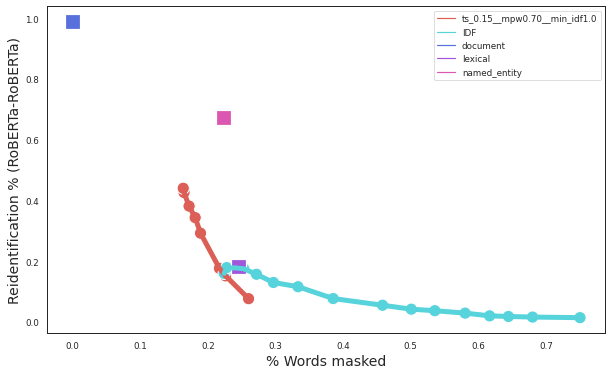

In [59]:
import matplotlib.pyplot as plt

def make_reid_plot(reid_model_name: str, x_column: str, xlabel: str, ylabel: str, marker_size: int = 150, set_lim=True):
    plt.figure(figsize=(10,6))
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    
    group_key = "group_name"
    
    # df_grouped_filtered = df_grouped
    df_grouped_filtered = df_grouped[
        df_grouped[group_key].apply(lambda row_model_name: (reid_model_name not in row_model_name))
    ]
    
    def should_we_keep_this_line(group_name: str) -> bool:
        if group_name.startswith("ts"):
            return group_name == 'ts_0.15__mpw0.70__min_idf1.0'
        else:
            return True
    df_grouped_filtered = df_grouped[df_grouped["group_name"].map(should_we_keep_this_line)]
    # print(df_grouped_filtered)
    y_column = f"{reid_model_name}__was_correct"
    
    g1 = sns.lineplot(
        data=df_grouped_filtered,
        x=x_column,
        y=y_column,
        hue=group_key,
        palette=color_by_model_name,
        linewidth=5,
        legend=True
    )
    # g1.set_xscale('log')
    g1.legend(loc='upper right')
    if set_lim: g1.set(xlim=(.18,.8), ylim=(-0.05, 0.45))
    for marker_type in df_grouped["marker"].unique():
        df_grouped_marker = df_grouped_filtered[
            df_grouped_filtered["marker"] == marker_type
        ]
        g2 = sns.scatterplot(
            data=df_grouped_marker,
            x=x_column,
            y=y_column,
            hue=group_key,
            palette=color_by_model_name,
            s=(marker_size if marker_type == 'o' else marker_size*1.5),
            marker=marker_type,
            legend=False
        )
        # g2.set_xscale('log')
    if set_lim: g2.set(xlim=(.18,.8), ylim=(-0.05, 0.45))


make_reid_plot(reid_model_name="roberta_roberta", x_column="percent_masks", ylabel="Reidentification % (RoBERTa-RoBERTa)", xlabel="% Words masked", set_lim=False)

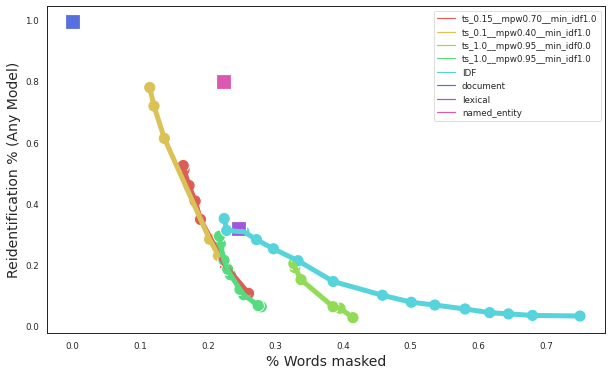

In [56]:
make_reid_plot(reid_model_name="any_model", x_column="percent_masks", ylabel="Reidentification % (Any Model)", xlabel="% Words masked", set_lim=False)

In [ ]:
make_reid_plot(reid_model_name="roberta_roberta", x_column="num_masks", ylabel="Reidentification % (RoBERTa-RoBERTa)", xlabel="Num words masked", set_lim=False)

In [60]:
out_df["group_name"] = out_df.apply(get_group_name, axis=1)

In [83]:
important_filenames = [
    # IDF-weighted, 29.7% masked, 25.1% reidentifiable
    '/home/jxm3/research/deidentification/unsupervised-deidentification/adv_csvs_full_8/model_3_4/results__b_1__ts100.0__nomodel__idf0.0__mp1.0__mig7.0__epsNone__k_0__n_1000__type_swap.csv',
#   # Deidentified by our model, 27.8% masked, 6.1% re-identifiable
    '/home/jxm3/research/deidentification/unsupervised-deidentification/adv_csvs_full_8/model_3_4/results__b_1__ts1.0__idf1.0__mp0.95__eps0.0005__k_None__n_1000__type_swap.csv',
#   # documents: 0% masked, 99.6% identifiable
     'document',
#   # lexically-redacted: 24.5% masked, 31.9% identifiable
    'lexical',
    # named-entity-redacted: 22.2% masked, 79.7% identifiable
    'named_entity',
]

In [70]:
df_grouped[df_grouped["group_name"] == "IDF"][df_grouped[df_grouped["group_name"] == "IDF"].index == 43]["filename"].iloc[0]

'/home/jxm3/research/deidentification/unsupervised-deidentification/adv_csvs_full_8/model_3_4/results__b_1__ts100.0__nomodel__idf0.0__mp1.0__mig7.0__epsNone__k_0__n_1000__type_swap.csv'

In [85]:
df_grouped[df_grouped["filename"].map(lambda s: s in important_filenames)]

,filename,original_score,perturbed_score,original_output,perturbed_output,ground_truth_output,num_queries,min_percent_words,k,eps,...,roberta_tapas__was_correct,roberta_roberta__was_correct,pmlm_tapas__was_correct,any_model__was_correct,num_masks,percent_masks,percent_not_masks,group_name,marker,color
19,/home/jxm3/research/deidentification/unsupervi...,-16.16704,1.225465,1244.434593,74690.546512,496.296512,423.81686,0.95,0.0,0.0005,...,0.031977,0.030523,0.000,0.061047,17.712209,0.278811,0.721189,ts_1.0__mpw0.95__min_idf1.0,o,"(0.33999999999999997, 0.86, 0.5012000000000001)"
43,/home/jxm3/research/deidentification/unsupervi...,-1.00000,4.783171,0.000000,0.000000,499.500000,705.09400,1.00,0.0,0.0000,...,0.165000,0.130000,0.092,0.251000,17.634000,0.296799,0.703201,IDF,o,"(0.33999999999999997, 0.8287999999999999, 0.86)"
46,document,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00,0.0,0.0000,...,0.992000,0.991000,0.986,0.996000,0.000000,0.000000,1.000000,document,s,"(0.33999999999999997, 0.43879999999999986, 0.86)"
47,lexical,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00,0.0,0.0000,...,0.213000,0.184000,0.143,0.319000,14.588000,0.245531,0.754469,lexical,s,"(0.6311999999999998, 0.33999999999999997, 0.86)"
48,named_entity,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00,0.0,0.0000,...,0.542000,0.674000,0.651,0.797000,13.234000,0.222742,0.777258,named_entity,s,"(0.86, 0.33999999999999997, 0.6987999999999996)"


In [79]:
df_grouped[df_grouped["filename"].map(lambda s: s in important_filenames)]

,filename,original_score,perturbed_score,original_output,perturbed_output,ground_truth_output,num_queries,min_percent_words,k,eps,...,roberta_tapas__was_correct,roberta_roberta__was_correct,pmlm_tapas__was_correct,any_model__was_correct,num_masks,percent_masks,percent_not_masks,group_name,marker,color


In [91]:
out_df.columns

Index(['original_person', 'original_text', 'perturbed_person',
       'perturbed_text', 'original_score', 'perturbed_score',
       'original_output', 'perturbed_output', 'ground_truth_output',
       'num_queries', 'result_type', 'filename', 'min_percent_words', 'k',
       'eps', 'n', 'num_examples_offset', 'beam_width', 'table_score',
       'fuzzy_ratio', 'min_idf_weighting', 'max_idf_goal', 'model_name',
       'use_train_profiles', 'use_type_swap', 'ignore_stopwords', 'no_model',
       'i', 'model', 'original_num_words', 'num_words',
       'pmlm_tapas_pred_topk_values', 'pmlm_tapas__pred_topk_idxs',
       'roberta_tapas__was_correct', 'roberta_tapas__topk_idxs',
       'roberta_tapas__topk_values', 'roberta_roberta__was_correct',
       'roberta_roberta__topk_idxs', 'roberta_roberta__topk_values',
       'pmlm_tapas__was_correct', 'pmlm_tapas__topk_idxs',
       'pmlm_tapas__topk_values', 'any_model__was_correct', 'num_masks',
       'group_name'],
      dtype='object')

In [109]:
keep_columns = [
    'perturbed_text',
    'num_queries',
    'num_words', 'i',
    'pmlm_tapas_pred_topk_values', 'pmlm_tapas__pred_topk_idxs',
    'roberta_tapas__was_correct', 'roberta_tapas__topk_idxs',
    'roberta_tapas__topk_values', 'roberta_roberta__was_correct',
    'roberta_roberta__topk_idxs', 'roberta_roberta__topk_values',
    'pmlm_tapas__was_correct', 'pmlm_tapas__topk_idxs',
    'pmlm_tapas__topk_values', 'any_model__was_correct', 'num_masks',
    'group_name'
]
analysis_df = out_df[out_df["filename"].map(lambda s: s in important_filenames)][keep_columns]
analysis_df["group_name"] = analysis_df["group_name"].replace({"ts_1.0__mpw0.95__min_idf1.0": "pmlm_tapas__eps_0.0005", "IDF": "idf__maxidf_7.0"})
final_analysis_df = analysis_df.rename(columns={"group_name": "deid_method"})

In [110]:
final_analysis_df.to_parquet('../wikibio_redacted_2.parquet.gzip', compression='gzip')

In [112]:
final_analysis_df.groupby("deid_method").mean()["pmlm_tapas__was_correct"]

deid_method
document                  0.986
idf__maxidf_7.0           0.092
lexical                   0.143
named_entity              0.651
pmlm_tapas__eps_0.0005    0.000
Name: pmlm_tapas__was_correct, dtype: float64